# Unsupervised Learning: Student Segmentation

This notebook applies unsupervised learning techniques to discover student segments and patterns.

## Techniques
1. **K-Means Clustering** - Segment students by academic profile
2. **PCA** - Dimensionality reduction and visualization
3. **t-SNE** - Complex pattern visualization

In [7]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Check if we are in the 'notebooks' directory and move up if so
if current_dir.endswith("notebooks"):
    os.chdir("..") # Move up one level to project root
    sys.path.append(os.getcwd()) # Add project root to python path

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude


In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
RESULTS_DIR = PROJECT_ROOT / 'results' / 'figures'

print(f"Loading data from: {PROCESSED_DIR}")

Loading data from: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/data/processed


In [9]:
# Load processed features
full_features = pd.read_csv(PROCESSED_DIR / 'full_features.csv')
print(f"Loaded {len(full_features)} students with {len(full_features.columns)} features")

Loaded 3718 students with 48 features


## 1. Data Preparation for Clustering

Select numeric features and handle missing values.

In [10]:
# Select features for clustering
clustering_features = [
    # Academic performance
    'y1_gpa_mean', 'y1_gpa_min', 'y1_gpa_max', 'y1_gpa_std',
    'y1_cgpa_end', 'y1_gpa_trend',
    'y1_courses_taken', 'y1_fail_count', 'y1_fail_rate', 'y1_a_rate',
    # HS exam scores
    'hs_mathematics', 'hs_english_language', 'hs_best_science', 'hs_aggregate_score',
    # Math track
    'math_track_encoded', 'first_math_grade_point'
]

# Filter to available features
available_features = [f for f in clustering_features if f in full_features.columns]
print(f"Using {len(available_features)} features for clustering:")
for f in available_features:
    print(f"  - {f}")

# Create clustering dataset
cluster_data = full_features[['student_id'] + available_features].copy()

# Check missing values
print(f"\nMissing values:")
print(cluster_data[available_features].isnull().sum())

Using 16 features for clustering:
  - y1_gpa_mean
  - y1_gpa_min
  - y1_gpa_max
  - y1_gpa_std
  - y1_cgpa_end
  - y1_gpa_trend
  - y1_courses_taken
  - y1_fail_count
  - y1_fail_rate
  - y1_a_rate
  - hs_mathematics
  - hs_english_language
  - hs_best_science
  - hs_aggregate_score
  - math_track_encoded
  - first_math_grade_point

Missing values:
y1_gpa_mean                500
y1_gpa_min                 500
y1_gpa_max                 500
y1_gpa_std                 500
y1_cgpa_end                500
y1_gpa_trend               500
y1_courses_taken           526
y1_fail_count              500
y1_fail_rate               526
y1_a_rate                  526
hs_mathematics            2283
hs_english_language       2442
hs_best_science           2932
hs_aggregate_score        2263
math_track_encoded          82
first_math_grade_point      82
dtype: int64


In [11]:
# Filter to students with sufficient data
# Require at least 50% of features to be non-null
threshold = len(available_features) * 0.5
cluster_data['feature_count'] = cluster_data[available_features].notna().sum(axis=1)
cluster_data_filtered = cluster_data[cluster_data['feature_count'] >= threshold].copy()

print(f"Students with sufficient data: {len(cluster_data_filtered)} / {len(cluster_data)}")

# Impute remaining missing values with median
X = cluster_data_filtered[available_features].copy()
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=available_features, index=X.index)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"\nPrepared data shape: {X_scaled.shape}")

Students with sufficient data: 3204 / 3718

Prepared data shape: (3204, 16)


## 2. K-Means Clustering

Find optimal number of clusters and segment students.

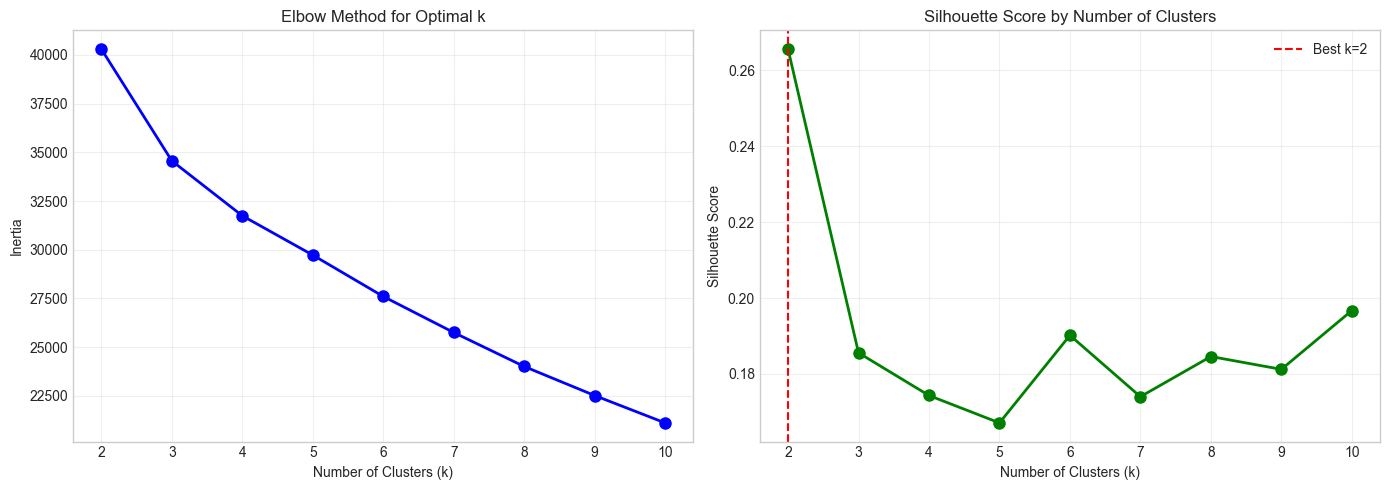


Optimal k based on silhouette score: 2


In [12]:
# Find optimal k using elbow method and silhouette score
k_range = range(2, 11)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax1 = axes[0]
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

# Silhouette plot
ax2 = axes[1]
ax2.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by Number of Clusters')
ax2.grid(True, alpha=0.3)

# Mark best silhouette
best_k = k_range[np.argmax(silhouettes)]
ax2.axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k}')
ax2.legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'clustering_optimal_k.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nOptimal k based on silhouette score: {best_k}")

In [14]:
# Fit K-Means with optimal k (or use 4 for interpretability)
n_clusters = 4  # 4 clusters for interpretable segments
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_data_filtered['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Cluster distribution:")
print(cluster_data_filtered['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0    1229
1     187
2     986
3     802
Name: count, dtype: int64


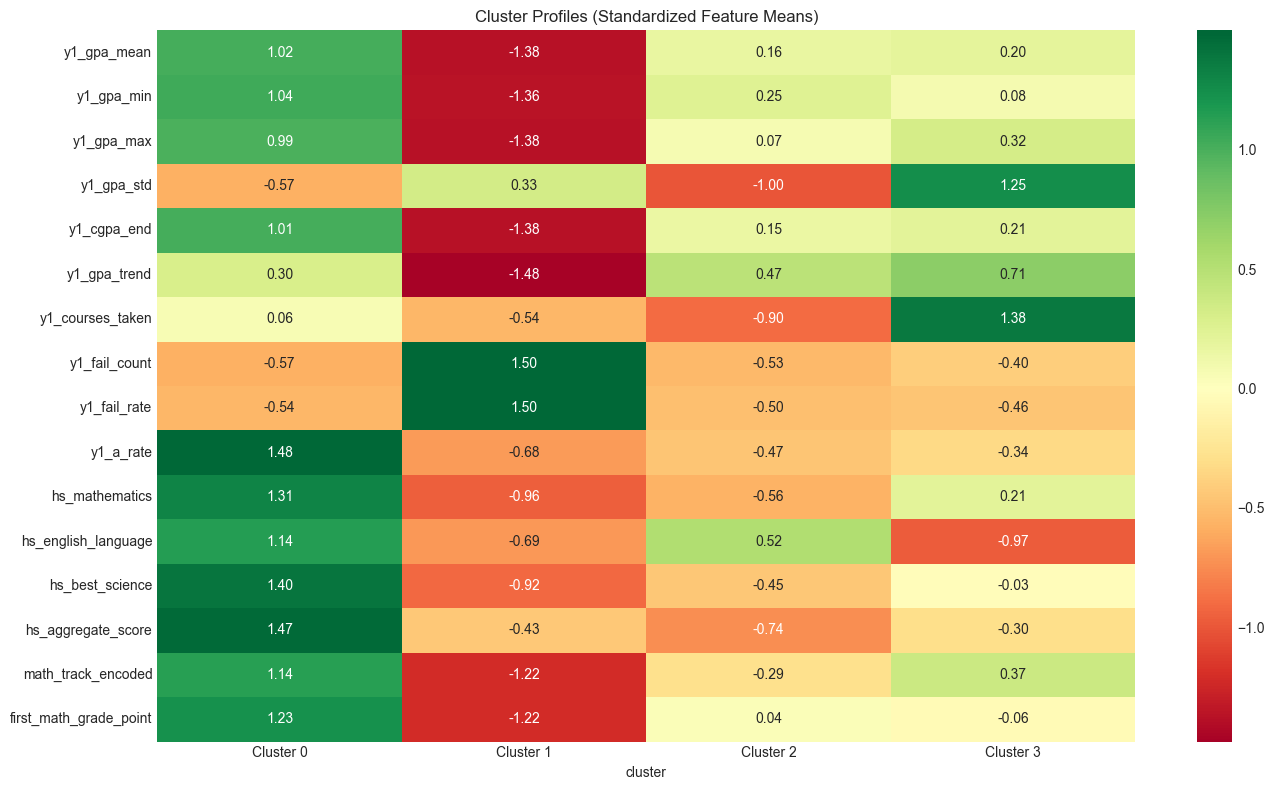


Cluster Profiles (Raw Means):


cluster,0,1,2,3
y1_gpa_mean,3.519154,1.103503,2.658129,2.693198
y1_gpa_min,3.477966,0.980588,2.656247,2.486110
y1_gpa_max,3.560342,1.226417,2.660010,2.900287
y1_gpa_std,0.058249,0.173827,0.002661,0.292867
y1_cgpa_end,3.518218,1.125241,2.658895,2.717469
y1_gpa_trend,-0.011505,-0.127433,-0.000477,0.015175
y1_courses_taken,7.124491,5.827027,5.040733,9.974874
y1_fail_count,0.004068,1.919786,0.046653,0.164589
y1_fail_rate,0.000827,0.367796,0.009131,0.016764
y1_a_rate,0.343093,0.004024,0.038187,0.058504


In [15]:
# Analyze cluster profiles
cluster_profiles = cluster_data_filtered.groupby('cluster')[available_features].mean()

# Visualize cluster profiles
fig, ax = plt.subplots(figsize=(14, 8))

# Normalize for visualization
cluster_profiles_norm = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

# Heatmap
sns.heatmap(cluster_profiles_norm.T, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            xticklabels=[f'Cluster {i}' for i in range(n_clusters)],
            ax=ax)
ax.set_title('Cluster Profiles (Standardized Feature Means)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'cluster_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

# Display raw means
print("\nCluster Profiles (Raw Means):")
display(cluster_profiles.T)

In [16]:
# Name clusters based on profiles
def name_cluster(cluster_id, profiles):
    """Assign interpretable names to clusters."""
    row = profiles.loc[cluster_id]
    
    # Logic based on GPA and failure rate
    if row.get('y1_gpa_mean', 3) >= 3.3 and row.get('y1_fail_rate', 0) < 0.1:
        return 'High Performers'
    elif row.get('y1_gpa_mean', 3) < 2.5 or row.get('y1_fail_rate', 0) > 0.3:
        return 'At-Risk Students'
    elif row.get('y1_gpa_trend', 0) > 0.2:
        return 'Improving Students'
    elif row.get('y1_gpa_trend', 0) < -0.2:
        return 'Declining Students'
    else:
        return 'Average Performers'

cluster_names = {i: name_cluster(i, cluster_profiles) for i in range(n_clusters)}
print("\nCluster Names:")
for cluster_id, name in cluster_names.items():
    count = (cluster_data_filtered['cluster'] == cluster_id).sum()
    print(f"  Cluster {cluster_id}: {name} ({count} students)")

cluster_data_filtered['cluster_name'] = cluster_data_filtered['cluster'].map(cluster_names)


Cluster Names:
  Cluster 0: High Performers (1229 students)
  Cluster 1: At-Risk Students (187 students)
  Cluster 2: Average Performers (986 students)
  Cluster 3: Average Performers (802 students)


## 3. PCA: Dimensionality Reduction

In [18]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cluster_data_filtered['pca_1'] = X_pca[:, 0]
cluster_data_filtered['pca_2'] = X_pca[:, 1]

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

Explained variance ratio: [0.37026941 0.11506948]
Total variance explained: 48.5%


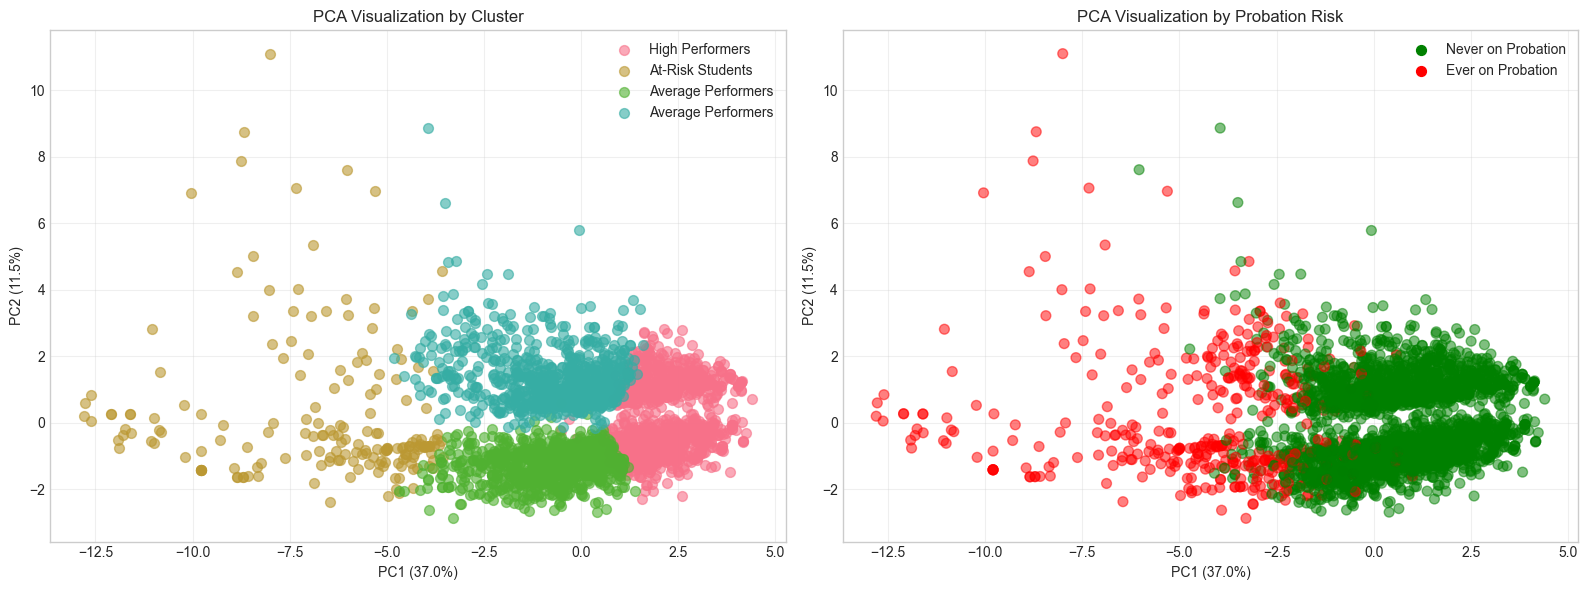

In [19]:
# Visualize PCA with clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA colored by cluster
ax1 = axes[0]
for cluster_id in range(n_clusters):
    mask = cluster_data_filtered['cluster'] == cluster_id
    ax1.scatter(cluster_data_filtered.loc[mask, 'pca_1'], 
                cluster_data_filtered.loc[mask, 'pca_2'],
                label=cluster_names[cluster_id], alpha=0.6, s=50)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('PCA Visualization by Cluster')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PCA colored by target (probation risk)
ax2 = axes[1]
# Merge target variable
targets = pd.read_csv(PROCESSED_DIR / 'targets.csv')
cluster_with_target = cluster_data_filtered.merge(targets[['student_id', 'target_ever_probation']], 
                                                   on='student_id', how='left')

colors = cluster_with_target['target_ever_probation'].map({0: 'green', 1: 'red'})
ax2.scatter(cluster_with_target['pca_1'], cluster_with_target['pca_2'],
            c=colors, alpha=0.5, s=50)
ax2.scatter([], [], c='green', label='Never on Probation', s=50)
ax2.scatter([], [], c='red', label='Ever on Probation', s=50)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_title('PCA Visualization by Probation Risk')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'pca_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

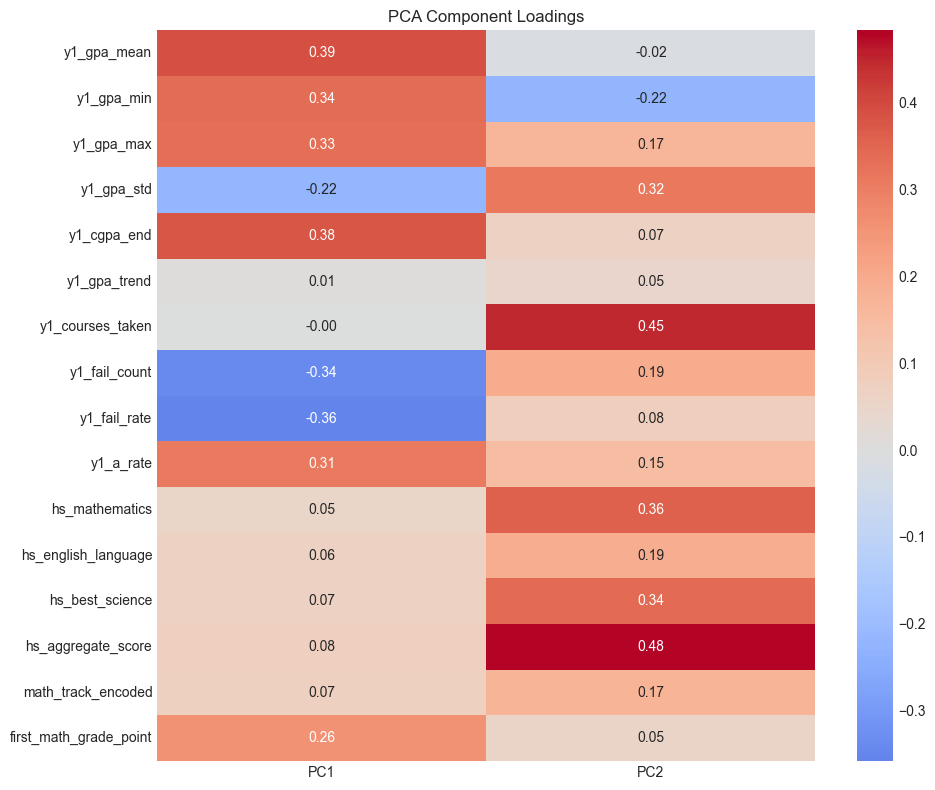


Top features for each component:

PC1:
  y1_gpa_mean: 0.391
  y1_cgpa_end: 0.379
  y1_fail_rate: -0.358
  y1_fail_count: -0.339
  y1_gpa_min: 0.338

PC2:
  hs_aggregate_score: 0.484
  y1_courses_taken: 0.450
  hs_mathematics: 0.360
  hs_best_science: 0.342
  y1_gpa_std: 0.315


In [12]:
# PCA component loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=available_features)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(loadings, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('PCA Component Loadings')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'pca_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop features for each component:")
for pc in ['PC1', 'PC2']:
    top = loadings[pc].abs().sort_values(ascending=False).head(5)
    print(f"\n{pc}:")
    for feat, val in top.items():
        print(f"  {feat}: {loadings.loc[feat, pc]:.3f}")

## 4. t-SNE Visualization

In [20]:
# Apply t-SNE (sample for speed if needed)
sample_size = min(2000, len(X_scaled))
np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)

X_sample = X_scaled[sample_idx]
clusters_sample = cluster_data_filtered.iloc[sample_idx]['cluster'].values

print(f"Running t-SNE on {sample_size} samples...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_sample)
print("t-SNE complete!")

Running t-SNE on 2000 samples...
t-SNE complete!


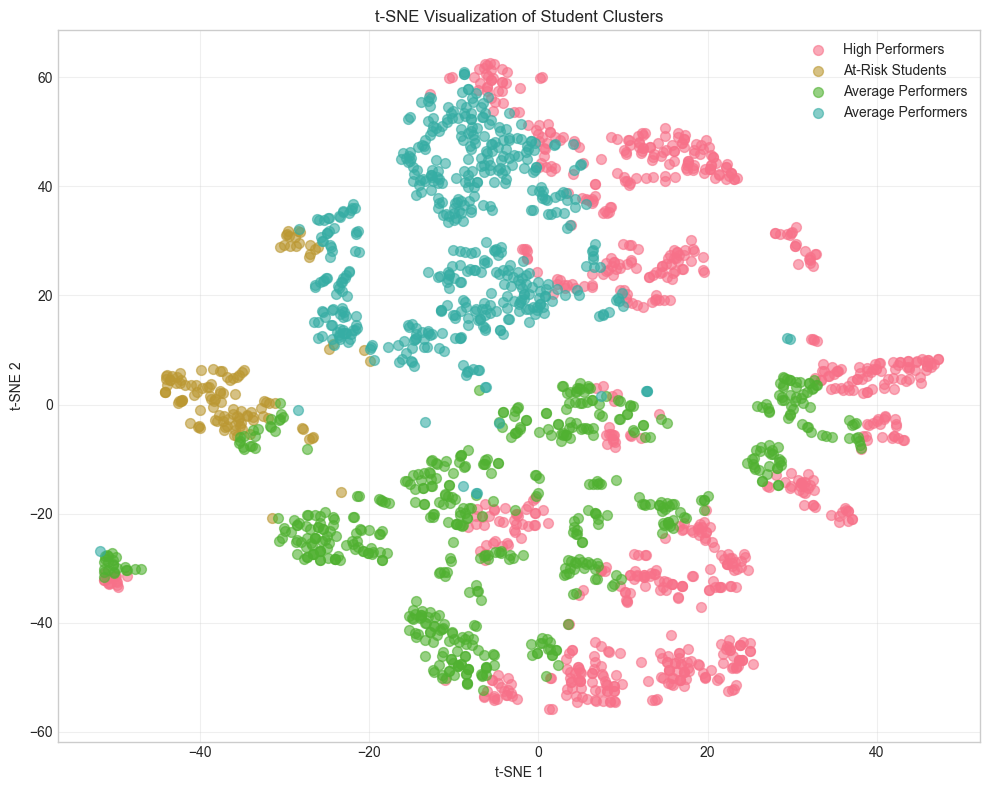

In [21]:
# Visualize t-SNE
fig, ax = plt.subplots(figsize=(10, 8))

for cluster_id in range(n_clusters):
    mask = clusters_sample == cluster_id
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               label=cluster_names[cluster_id], alpha=0.6, s=50)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE Visualization of Student Clusters')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Cluster Analysis by Outcomes

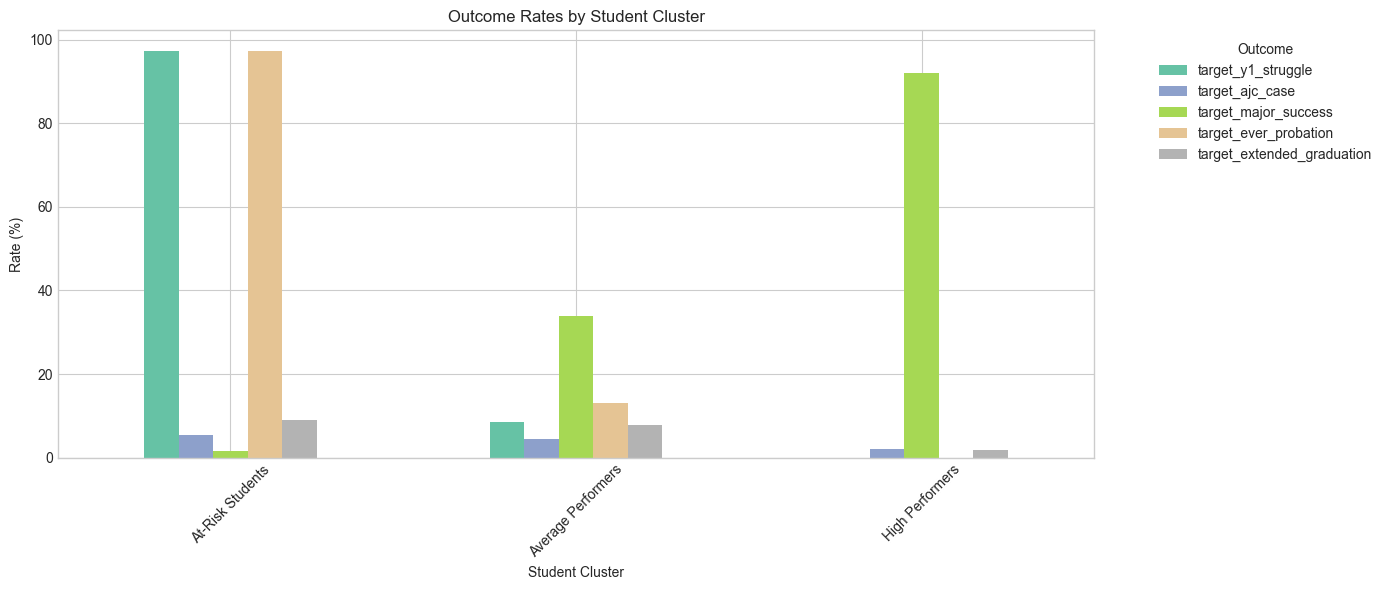


Outcome Rates by Cluster:


,target_y1_struggle,target_ajc_case,target_major_success,target_ever_probation,target_extended_graduation
cluster_name,,,,,
At-Risk Students,97.3,5.3,1.6,97.3,9.1
Average Performers,8.6,4.4,33.8,13.1,7.8
High Performers,0.0,2.1,91.9,0.0,2.0


In [22]:
# Merge all targets
targets = pd.read_csv(PROCESSED_DIR / 'targets.csv')
cluster_analysis = cluster_data_filtered.merge(targets, on='student_id', how='left')

# Outcome rates by cluster
target_cols = ['target_y1_struggle', 'target_ajc_case', 'target_major_success', 
               'target_ever_probation', 'target_extended_graduation']

outcome_by_cluster = cluster_analysis.groupby('cluster_name')[target_cols].mean() * 100

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))
outcome_by_cluster.plot(kind='bar', ax=ax, colormap='Set2')
ax.set_xlabel('Student Cluster')
ax.set_ylabel('Rate (%)')
ax.set_title('Outcome Rates by Student Cluster')
ax.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'outcomes_by_cluster.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nOutcome Rates by Cluster:")
display(outcome_by_cluster.round(1))

## 6. Save Cluster Assignments

In [23]:
# Save cluster assignments
cluster_output = cluster_data_filtered[['student_id', 'cluster', 'cluster_name', 'pca_1', 'pca_2']]
cluster_output.to_csv(PROCESSED_DIR / 'student_clusters.csv', index=False)
print(f"Saved cluster assignments to: {PROCESSED_DIR / 'student_clusters.csv'}")

print("\n" + "="*60)
print(" UNSUPERVISED LEARNING COMPLETE ")
print("="*60)
print(f"\nKey findings:")
print(f"  - Identified {n_clusters} distinct student segments")
print(f"  - PCA explains {sum(pca.explained_variance_ratio_)*100:.1f}% of variance in 2 components")
print(f"  - Clusters show clear separation in outcome rates")
print(f"\nNext notebook: 05_supervised_rq1_rq2.ipynb")

Saved cluster assignments to: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/data/processed/student_clusters.csv

 UNSUPERVISED LEARNING COMPLETE 

Key findings:
  - Identified 4 distinct student segments
  - PCA explains 48.5% of variance in 2 components
  - Clusters show clear separation in outcome rates

Next notebook: 05_supervised_rq1_rq2.ipynb
